In [1]:
from cplAE_MET.utils.load_helpers import get_paths as V2_paths
from cplAE_TE.utils.load_helpers import get_paths as V1_paths
from cplAE_TE.utils.load_helpers import load_dataset as v1_load_dataset

from pathlib import Path
import pandas as pd
import numpy as np
import scipy.io as sio
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Location copied on Apr 29 2021: 
 - from: `/allen/programs/celltypes/workgroups/mousecelltypes/MachineLearning/Olga/morphology/arbor_density_ae/data121120/`
 - to: `~/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-inh/morphology/`

In [2]:
v2_paths = V2_paths()
v1_paths = V1_paths()

v1_TE_data = v1_load_dataset(min_sample_thr=10)
v2_t_anno = pd.read_csv(v2_paths['v2_t_anno'])
v2_t_data = pd.read_csv(v2_paths['v2_t_data'])
v2_e_data = pd.read_csv(v2_paths['v2_e_data'])

In [3]:
data_path = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-inh/morphology/data121120/hist2d_120x4_manual_auto/'
m_anno =  pd.read_csv('/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-inh/morphology/data121120/manual_auto823.csv')

In [4]:
#Compare number of M cells available in the different versions of the TE patch-seq dataset:
v1_m_anno = m_anno[m_anno['specimen_id'].isin(v1_TE_data['T_spec_id_label'])].reset_index(drop=True)
v2_m_anno = m_anno[m_anno['specimen_id'].isin(v2_t_anno['spec_id_label'])].reset_index(drop=True)

v2_t_mat = v2_t_data.values[:,1:] # first column is cell identifier
v2_e_mat = v2_e_data.values[:,1:] # first column is cell identifier

print(f'{v1_m_anno.shape[0]} cells in v1 data')
print(f'{v2_m_anno.shape[0]} cells in v2 data')

683 cells in v1 data
721 cells in v2 data


In [5]:
hist_shape = (1,120,4,1)
im_shape = (1,120,4,2)
ax_list = []
de_list = []
im = np.zeros((v2_t_anno['spec_id_label'].size,120,4,2),dtype=float)
soma_depth = np.zeros((v2_t_anno['spec_id_label'].size,))
count=0
for i,spec_id in tqdm(enumerate(v2_t_anno['spec_id_label'])):
    if Path(data_path+f'hist2d_120x4_axon_{spec_id}.csv').is_file():
        
        im_ax = pd.read_csv(data_path+f'hist2d_120x4_axon_{spec_id}.csv',header=None).values
        im_de = pd.read_csv(data_path+f'hist2d_120x4_dendrite_{spec_id}.csv',header=None).values
        
        #Normalize
        ax_list.append(np.sum(im_ax))
        de_list.append(np.sum(im_de))
        im_ax = im_ax*1e2/np.sum(im_ax)
        im_de = im_de*1e2/np.sum(im_de)
        
        im[i,...] = (np.concatenate([im_de.reshape(hist_shape),im_ax.reshape(hist_shape)],axis=3))
        soma_depth[i] = np.squeeze(m_anno.loc[m_anno['specimen_id']==spec_id]['soma_depth'].values)
        count = count+1
    else:
        im[i,...] =  np.full(im_shape, np.nan)
        soma_depth[i] = np.nan

print(f'found data for {count} morphologies')

3819it [00:03, 1120.32it/s]found data for 721 morphologies



Text(0.5, 0, 'sorted cell')

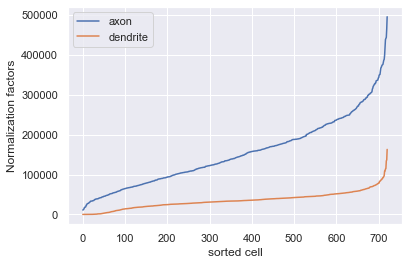

In [6]:
plt.plot(np.sort(ax_list),label = 'axon')
plt.plot(np.sort(de_list),label = 'dendrite')
plt.legend()
plt.ylabel('Normalization factors')
plt.xlabel('sorted cell')

In [7]:
ind = np.argsort(v2_t_anno['cluster_id'].values)

#keep only cells with m data
keep = ~(np.isnan(np.sum(im,axis=(1,2,3))))
keep = keep[ind]
ind = ind[keep]

#### Show 1d densities

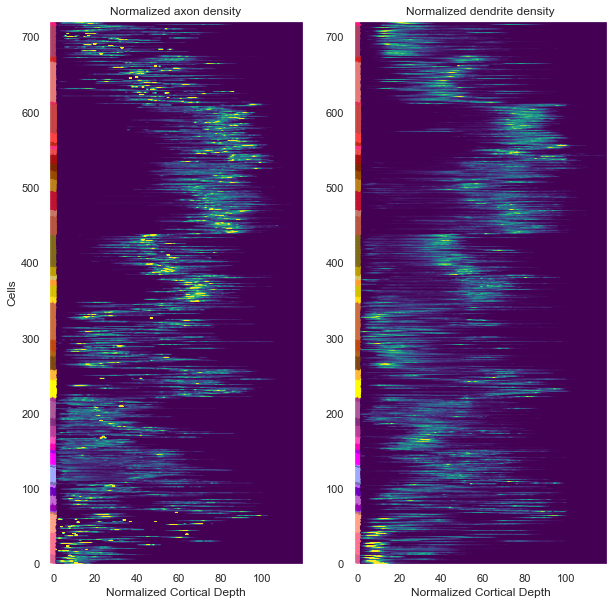

In [8]:
plt.figure(figsize=(10,10))

plt.subplot(121)
x = np.sum(im[ind,...,0],axis=2)
x = x/(np.sum(x,axis=1,keepdims=True)+1e-5)
plt.imshow(x,aspect='auto',vmin=0,vmax=.1,cmap='viridis')
plt.scatter(-2+np.zeros(ind.shape),np.arange(ind.size),s=100,c=v2_t_anno['cluster_color'][ind],marker='_')
plt.scatter(soma_depth[ind]*im_shape[0],np.arange(ind.size),s=20,c=v2_t_anno['cluster_color'][ind],marker='.',alpha = 1)

ax = plt.gca()
ax.grid(False)
ax.set_ylim(-0.5,ind.size+0.5)
ax.set_xlim(-2,ax.get_xlim()[1])
ax.set_xlabel('Normalized Cortical Depth')
ax.set_ylabel('Cells')
ax.set_title('Normalized axon density')
ylim = ax.get_ylim()


plt.subplot(122)
x = np.sum(im[ind,...,1],axis=2)
x = x/(np.sum(x,axis=1,keepdims=True)+1e-5)
plt.imshow(x,aspect='auto',vmin=0,vmax=0.1,cmap='viridis')
plt.scatter(-2+np.zeros(ind.shape),np.arange(ind.size),s=100,c=v2_t_anno['cluster_color'][ind],marker='_')
plt.scatter(soma_depth[ind]*im_shape[0],np.arange(ind.size),s=20,c=v2_t_anno['cluster_color'][ind],marker='.',alpha = 1)

ax = plt.gca()
ax.grid(False)
ax.set_ylim(-0.5,ind.size+0.5)
ax.set_xlim(-2,ax.get_xlim()[1])
ax.set_xlabel('Normalized Cortical Depth')
ax.set_title('Normalized dendrite density')
plt.show()

#### Show some 2d densities

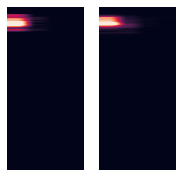

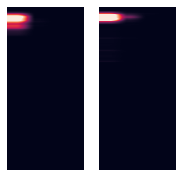

In [9]:
#Visual inspection of the histograms:
ind = np.flatnonzero(~np.isnan(soma_depth))
for i in ind[[1,2]]:
    plt.figure(figsize=(3,3))
    plt.subplot(121)
    plt.imshow(np.squeeze(im[i,...,0]),aspect='auto',vmin=0,vmax=10)
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(np.squeeze(im[i,...,1]),aspect='auto',vmin=0,vmax=10)
    plt.grid(False)
    plt.axis('off')
    plt.show()

### Save M data and annotations

In [10]:
sio.savemat(v2_paths['v2_m_data'],{'hist_ax_de':im,'soma_depth':soma_depth},do_compression=True)

In [11]:
m_ind = np.where(~np.isnan(soma_depth))[0]
m_avbl = v2_t_anno.loc[m_ind] # annotations for cells with morphology data

# select 5 test cells from clusters that are well-represented in the m data
m_avbl_well_sampled = m_avbl.groupby('cluster').filter(lambda x: len(x) > 15)
test_df = m_avbl_well_sampled.groupby('cluster').sample(n=5, random_state=1)

# use test indices to separate train samples
test_anno_df = v2_t_anno.loc[test_df.index]
train_anno_df = v2_t_anno.loc[~v2_t_anno.index.isin(test_df.index)]
sio.savemat(v2_paths['package'] / 'data/proc/train_test_splits.mat', {'train_ind':train_anno_df.index.values, 'test_ind':test_anno_df.index.values})

In [12]:
a_df = pd.read_csv('/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-tm-v1/auto280.csv')
M_anno = v2_t_anno[['spec_id_label', 'sample_id', 'cluster', 'cluster_color', 'cluster_id']].copy()
M_anno['reconstruction'] = "none"
M_anno.loc[M_anno['spec_id_label'].isin(m_avbl['spec_id_label']),'reconstruction'] = "manual"
M_anno.loc[M_anno['spec_id_label'].isin(a_df['specimen_id']),'reconstruction'] = "auto"

M_anno['soma_depth'] = soma_depth
M_anno.to_csv(v2_paths['v2_m_anno'], index=False)